# healpy tutorial

See the Jupyter Notebook version of this tutorial at <https://github.com/healpy/healpy/blob/master/doc/tutorial.ipynb>


Choose the `inline` backend of `maptlotlib` to display the plots inside the Jupyter Notebook

In [1]:
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import numpy as np
import healpy as hp
from healpy.newvisufunc import projview, newprojplot

## NSIDE and ordering

Maps are simply numpy arrays, where each array element refers to a location in the sky as defined by the Healpix pixelization schemes (see the [healpix website](https://healpix.jpl.nasa.gov/)).

Note: Running the code below in a regular Python session will not display the maps; it's recommended to use an IPython shell or a Jupyter notebook.

The resolution of the map is defined by the *NSIDE* parameter, which is generally a power of 2.

In [3]:
NSIDE = 8
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)

Approximate resolution at NSIDE 8 is 7.3 deg


The function `healpy.pixelfunc.nside2npix` gives the number of pixels *NPIX* of the map:

In [4]:
NPIX = hp.nside2npix(NSIDE)
print(NPIX)

768


The same pixels in the map can be ordered in 2 ways, either RING, where they are numbered in the array in horizontal rings starting from the North pole:

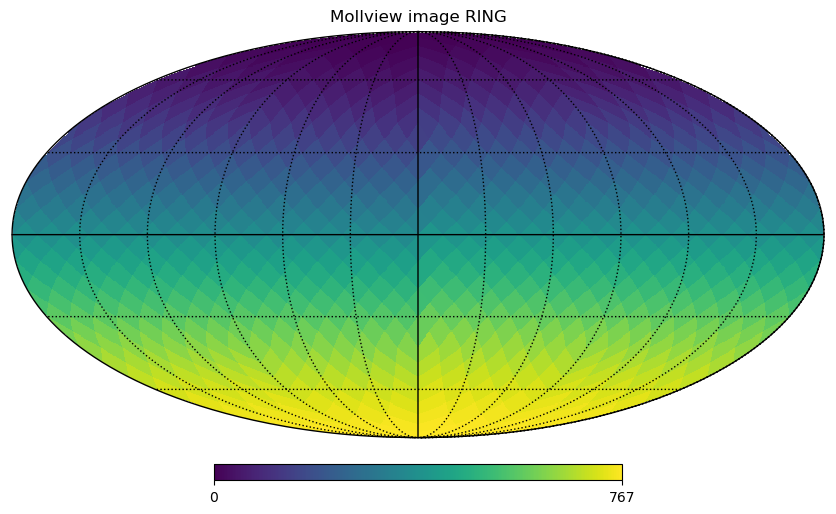

In [5]:
m = np.arange(NPIX)
hp.mollview(m, title="Mollview image RING")
hp.graticule()
plt.show()

The standard coordinates are the **colatitude** $\theta$, $0$ at the North Pole, $\pi/2$ at the equator and $\pi$ at the South Pole and the **longitude** $\phi$ between $0$ and $2\pi$ eastward, in a Mollview projection, $\phi=0$ is at the center and increases eastward toward the left of the map.

We can also use vectors to represent coordinates, for example `vec` is the normalized vector that points to $\theta=\pi/2, \phi=3/4\pi$:

In [6]:
vec = hp.ang2vec(np.pi / 2, np.pi *3/4)
print(vec)

[-7.07106781e-01  7.07106781e-01  6.12323400e-17]


We can find the indices of all the pixels within $10$ degrees of that point and then change the value of the map at those indices:

In [7]:
ipix_disc = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(10))

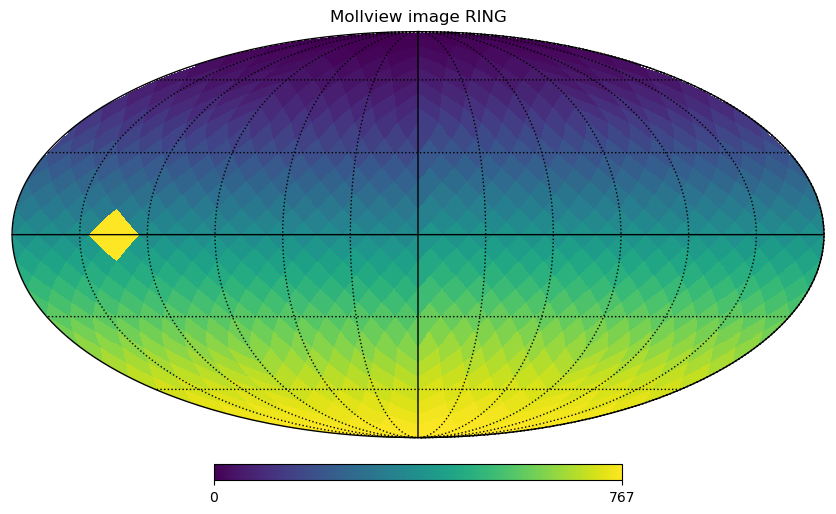

In [8]:
m = np.arange(NPIX)
m[ipix_disc] = m.max()
hp.mollview(m, title="Mollview image RING")
hp.graticule()

We can retrieve colatitude and longitude of each pixel using `pix2ang`, in this case we notice that the first 4 pixels cover the North Pole with pixel centers just ~$1.5$ degrees South of the Pole all at the same latitude. The fifth pixel is already part of another ring of pixels.

In [9]:
theta, phi = np.degrees(hp.pix2ang(nside=32, ipix=[0, 1, 2, 3, 4]))

In [10]:
theta

array([1.46197116, 1.46197116, 1.46197116, 1.46197116, 2.92418036])

In [11]:
phi

array([ 45. , 135. , 225. , 315. ,  22.5])

The RING ordering is necessary for the Spherical Harmonics transforms, the other option is NESTED ordering which is very efficient for map domain operations because scaling up and down maps is achieved just multiplying and rounding pixel indices.
See below how pixel are ordered in the NESTED scheme, notice the structure of the 12 HEALPix base pixels (NSIDE 1):

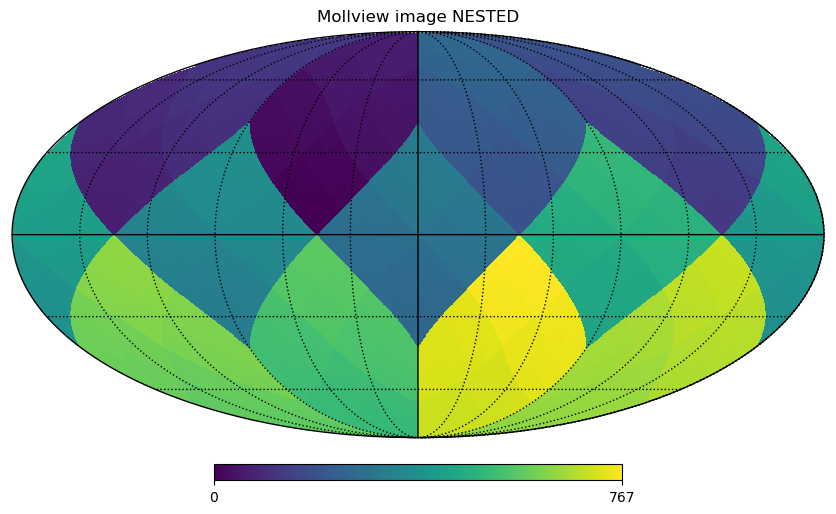

In [12]:
m = np.arange(NPIX)
hp.mollview(m, nest=True, title="Mollview image NESTED")
hp.graticule()

All `healpy` routines assume RING ordering, in fact as soon as you read a map with `read_map`, even if it was stored as NESTED, it is transformed to RING.
However, you can work in NESTED ordering passing the `nest=True` argument to most `healpy` routines.

## Reading and writing maps to file

For the following section, it is required to download larger maps by executing from the terminal the bash script ``healpy_get_wmap_maps.sh`` which should be available in your path.

This will download the higher resolution WMAP data into the current directory.

In [13]:
# !wget -c http://lambda.gsfc.nasa.gov/data/map/dr4/skymaps/7yr/raw/wmap_band_iqumap_r9_7yr_W_v4.fits;wget -c http://lambda.gsfc.nasa.gov/data/map/dr4/ancillary/masks/wmap_temperature_analysis_mask_r9_7yr_v4.fits

In [14]:
wmap_map_I = hp.read_map("wmap_temperature_analysis_mask_r9_7yr_v4.fits")

TimeoutError: [Errno 60] Operation timed out

By default, input maps are converted to *RING* ordering, if they are in *NESTED* ordering. You can otherwise specify `nest=True` to retrieve a     map is NESTED ordering, or `nest=None` to keep the ordering unchanged.

By default, `read_map` loads the first column, for reading other columns you can specify the `field` keyword.

`write_map` writes a map to disk in FITS format, if the input map is a list of 3 maps, they are written to a single file as I,Q,U polarization components:

In [ ]:
hp.write_map("my_map.fits", wmap_map_I, overwrite=True)

## Visualization

As shown above, mollweide projection with `mollview` is the most common visualization tool for HEALPIX maps. It also supports coordinate transformation, `coord` does Galactic to ecliptic coordinate transformation, `norm='hist'` sets a histogram equalized color scale and `xsize` increases the size   of the image. `graticule` adds meridians and parallels.


In [ ]:
hp.mollview(
    wmap_map_I,
    coord=["G", "E"],
    title="Histogram equalized Ecliptic",
    unit="mK",
    norm="hist",
    min=-1,
    max=1,
)
hp.graticule()

`gnomview` instead provides gnomonic projection around a position specified by `rot`, for example you can plot a projection of the galactic center, `xsize` and `ysize` change the dimension of the sky patch.

In [ ]:
hp.gnomview(wmap_map_I, rot=[0, 0.3], title="GnomView", unit="mK", format="%.2g")

`mollzoom` is a powerful tool for interactive inspection of a map, it provides a mollweide projection where you can click to set the center of the adjacent gnomview panel.
## Masked map, partial maps

By convention, HEALPIX uses $-1.6375 * 10^{30}$ to mark invalid or unseen pixels. This is stored in healpy as the constant `UNSEEN`.

All `healpy` functions automatically deal with maps with `UNSEEN` pixels, for example `mollview` marks in grey those sections of a map.

There is an alternative way of dealing with UNSEEN pixel based on the numpy`MaskedArray` class, `hp.ma` loads a map as a masked array, by convention the mask is 0 where the data are masked, while numpy defines data masked when the mask is True, so it is necessary to flip the mask.

In [ ]:
mask = hp.read_map("wmap_temperature_analysis_mask_r9_7yr_v4.fits").astype(np.bool_)
wmap_map_I_masked = hp.ma(wmap_map_I)
wmap_map_I_masked.mask = np.logical_not(mask)

Filling a masked array fills in the `UNSEEN` value and return a standard array that can be used by `mollview`.
`compressed()` instead removes all the masked pixels and returns a standard array that can be used for examples by the matplotlib `hist()` function:

In [ ]:
hp.mollview(wmap_map_I_masked.filled())

In [ ]:
plt.hist(wmap_map_I_masked.compressed(), bins=1000);

## Spherical Harmonics transforms

`healpy` provides bindings to the C++ HEALPIX library for performing spherical harmonic transforms.
`hp.anafast` computes the angular power spectrum of a map:

In [44]:
LMAX = 1024
cl = hp.anafast(wmap_map_I_masked.filled(), lmax=LMAX)
ell = np.arange(len(cl))

therefore we can plot a normalized CMB spectrum and write it to disk:

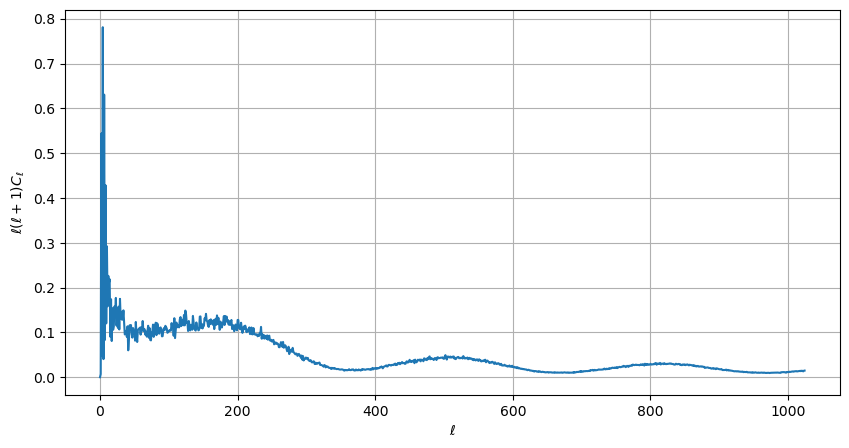

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(ell, ell * (ell + 1) * cl)
plt.xlabel("$\ell$")
plt.ylabel("$\ell(\ell+1)C_{\ell}$")
plt.grid()
hp.write_cl("cl.fits", cl, overwrite=True)

Gaussian beam map smoothing is provided by `hp.smoothing`:

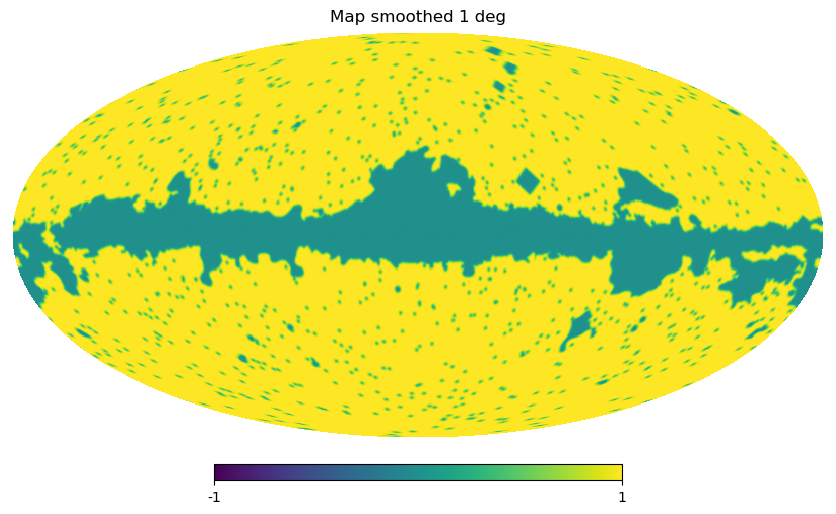

In [46]:
wmap_map_I_smoothed = hp.smoothing(wmap_map_I, fwhm=np.radians(1.))
hp.mollview(wmap_map_I_smoothed, min=-1, max=1, title="Map smoothed 1 deg")

For more information see the [HEALPix primer](https://healpix.jpl.nasa.gov/pdf/intro.pdf)